# Getting Started with Nearest Neighbors

### The Need for *Indexes*

Nearest-neighbor models like the Nearest-Neighbor Gaussian Process (NNGP) (Datta, et. al, 2016) demonstrate superior efficiency while maintaining model performance by assuming that an observation in the training set only depends on other observations that are "close" enough to be considered neighbors. However, the best definition of "close" for a given problem will depend on the data and the model, so a fixed definition of "close" will not always yield the best performance. The ability to use a variety of distance metrics in a nearest-neighbor model is crucial to finding the best model for the job.

Additionally, specifying a distance metric is not sufficient for determining neighbors, because the nearest-neighbor approximation further assumes that the dataset is *ordered*, and that only observations that come before a given observation in the ordering can be considered neighbors of that observation. So, the neighbors of an observation depend on the ordering of the dataset. There are many ways to order a dataset for optimal performance, and new ordering schemes are an active area of research.

To complicate things further, some nearest-neighbor models like the Block-Nearest-Neighbor Gaussian Process (BNNGP) (Quiroz, et. al, 2021) generalize the NNGP to assume that non-overlapping *sets of observations* depend on *neighboring sets of observations*. To construct these sets of observations, a variety of spatial clustering (blocking) algorithms have been considered, and the list of sensible choices is always expanding.

With a large and growing number ways to combine these three ingredients, we do not want to tie your models to a particular distance metric, ordering scheme, or clustering algorithm. Instead, we've built an interface called an *index* for blocking and ordering functionality that provides a set of sensible defaults, and enables easy customization to users looking to use unusual distance metrics, novel ordering schemes, or special clustering algorithms. To get started, let's dive into the defaults.

### Generating Data

First, we'll load the required libraries.

In [1]:
import gpytorch
import torch
import torch.distributions as distr

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (15,7)

torch.manual_seed(0)

Next, we'll generate a simple dataset from a known Gaussian Process.

In [2]:
def f(x):
    
    dist = torch.cdist(x,x)
    cov = 4*torch.exp(-(1/2*(0.1**2)) * dist) + 0.01*torch.eye(len(x))
    distr = torch.distributions.MultivariateNormal(loc = 3*torch.ones(len(x)), covariance_matrix = cov)
    
    return distr.rsample()

In [3]:
sample_size = 2000

# to create sample, first sample N random points from this domain 
x_all = torch.tensor([[x1,x2] for x1,x2 in zip(
    distr.Uniform(torch.tensor([0.0]),torch.tensor([5.0])).rsample(torch.tensor([sample_size])),
    distr.Uniform(torch.tensor([0.0]),torch.tensor([5.0])).rsample(torch.tensor([sample_size])))])

# now apply function to all N points
y_all = f(x_all).float()

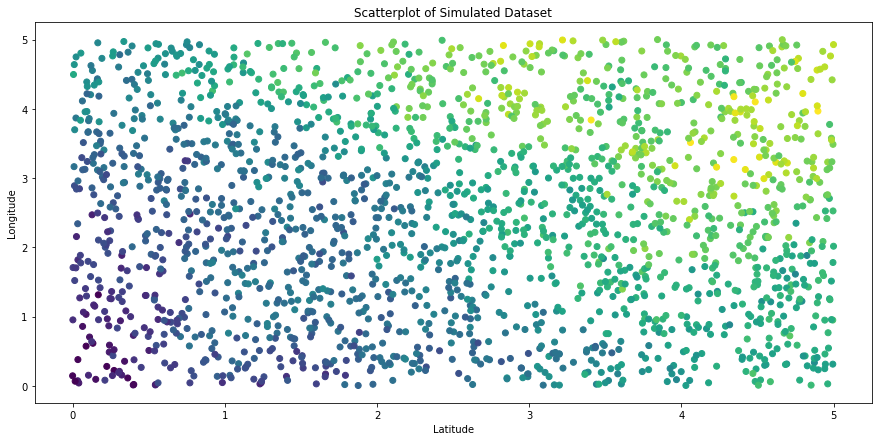

In [4]:
plt.scatter(x_all[:,0].numpy(), x_all[:,1].numpy(), c=y_all)
plt.title("Scatterplot of Simulated Dataset")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

Finally, we'll split our dataset into training and testing sets, and we will only use the training set in our index.

In [5]:
idx = torch.randperm(sample_size)
train_idx = idx[0:int(0.8*sample_size)]
test_idx = idx[int(0.8*sample_size):sample_size]

x_train = x_all[train_idx,:]
y_train = y_all[train_idx]

x_test = x_all[test_idx,:]
y_test = y_all[test_idx]

### Index for NNGP With K-Means

The basic interface for blocking/ordering functionality in this module is the `BaseIndex` class, from which all other indexes must inherit. We'll cover this more when we discuss custom indexes. For now, let's explore our default index that uses K-Means to cluster data into blocks, called `KMeansIndex`. This is stored in the GPyTorch's `nearest_neighbors` module, so we will import it from there.

In [6]:
from gpytorch.nearest_neighbors import KMeansIndex as Index
print(Index.__doc__) # print class docstring for info on constructor parameters


    This index performs K-Means clustering on a given feature set, computes neighboring blocks, enables
    evaluating block membership for test points, and enables reordering of the blocks based on block centroids.

    :param data: Features to cluster via K-Means, typically an n x 2 tensor of spatial lat-long coordinates.
    :param n_blocks: Number of desired clusters. Note that this does not guarantee similarly-sized clusters.
    :param n_neighbors: Number of neighboring clusters per cluster.
    


To fully define this index, we also must supply a distance metric per our earlier discussion. We've collected a number of common distance metrics in our `DistanceMetrics` class, so we will import that here.

In [7]:
from gpytorch.nearest_neighbors import DistanceMetrics

Let's use this to create an index for Nearest-Neighbors Gaussian Processes. In the NNGP model, we only consider singular observations and their neighbors, so want to divide our dataset into as many blocks as there are training observations. This ensures that each observation will belong to its own block. Note that this makes the choice of a K-Means clustering algorthim irrelevant, but this is still a sensible starting point. We will define each observation's neighborhood to be its 20 nearest neighbors, and the NNGP model generally uses the Euclidean distance metric to define closeness.

In [8]:
nn_idx = Index(x_train, n_blocks=len(x_train), n_neighbors=20,
               distance_metric=DistanceMetrics.euclidean_distance())

We can use the following code to plot the object (this was included in the base index object, but GPyTorch does not include matplotlib):

In [9]:
def idx_plot(idx, x: torch.tensor, y: torch.tensor, n_blocks: int = None, seed: int = 0):
    """
    Useful visualization for this object and the ordering of the blocks, only implemented for 2D features.

    :param x: Spatial coordinates to plot. This must be the same tensor that was used to construct the blocks.
    :param y: Response values corresponding to each spatial coordinate in x.
    :param n_blocks: Number of blocks to sample for the plot.
    :param seed: RNG seed to change which blocks get randomly sampled.
    """

    np.random.seed(seed)

    if n_blocks is not None:
        if n_blocks > len(idx._block_observations):
            raise ValueError("Number of blocks to plot must not exceed total number of blocks.")
    else:
        n_blocks = math.ceil(math.log(len(idx._block_observations)))

    ordered_x = torch.cat([x[idx._block_observations[i], :] for i in range(len(idx._block_observations))]).numpy()
    ordered_y = torch.cat([y[idx._block_observations[i]] for i in range(len(idx._block_observations))]).numpy()

    unique_color_vals = np.linspace(0, 1, len(idx._block_observations))
    unique_colors = np.array(
        [(unique_color_vals[i], 0, unique_color_vals[i]) for i in range(len(unique_color_vals))]
    )
    colors = np.repeat(unique_colors, [len(block) for block in idx._block_observations], axis=0)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.scatter(ordered_x[:, 0], ordered_x[:, 1], c=colors)
    plt.title("Ordered Features")

    plt.subplot(2, 2, 2)
    plt.scatter(ordered_x[:, 0], ordered_x[:, 1], c=ordered_y)
    plt.title("Response Values")

    # for a fixed sample of indices, this will always yield the same sampled_blocks regardless of reordering
    invariant_block_idx = torch.argsort(torch.stack([torch.max(block) for block in idx._block_observations]))
    sampled_blocks = invariant_block_idx[np.random.permutation(len(idx._block_observations))[:n_blocks]]

    plt.subplot(2, 2, 3)
    plt.scatter(ordered_x[:, 0], ordered_x[:, 1], c="grey", alpha=0.25)
    for sampled_block in sampled_blocks:
        plt.scatter(
            x[idx._block_observations[sampled_block], 0].numpy(),
            x[idx._block_observations[sampled_block], 1].numpy(),
            c="blue",
            s=50,
        )
        plt.scatter(
            x[idx._exclusive_neighboring_observations[sampled_block], 0].numpy(),
            x[idx._exclusive_neighboring_observations[sampled_block], 1].numpy(),
            c="deepskyblue",
            alpha=0.5,
        )
    plt.title("Ordered Neighbors")

    plt.subplot(2, 2, 4)
    plt.scatter(ordered_x[:, 0], ordered_x[:, 1], c="grey", alpha=0.25)
    for sampled_block in sampled_blocks:
        plt.scatter(
            x[idx._block_observations[sampled_block], 0].numpy(),
            x[idx._block_observations[sampled_block], 1].numpy(),
            c=y[idx._block_observations[sampled_block]].numpy(),
            vmin=torch.min(y),
            vmax=torch.max(y),
        )
        plt.scatter(
            x[idx._exclusive_neighboring_observations[sampled_block], 0].numpy(),
            x[idx._exclusive_neighboring_observations[sampled_block], 1].numpy(),
            c=y[idx._exclusive_neighboring_observations[sampled_block]].numpy(),
            vmin=torch.min(y),
            vmax=torch.max(y),
        )
    plt.title("Corresponding Response Values")

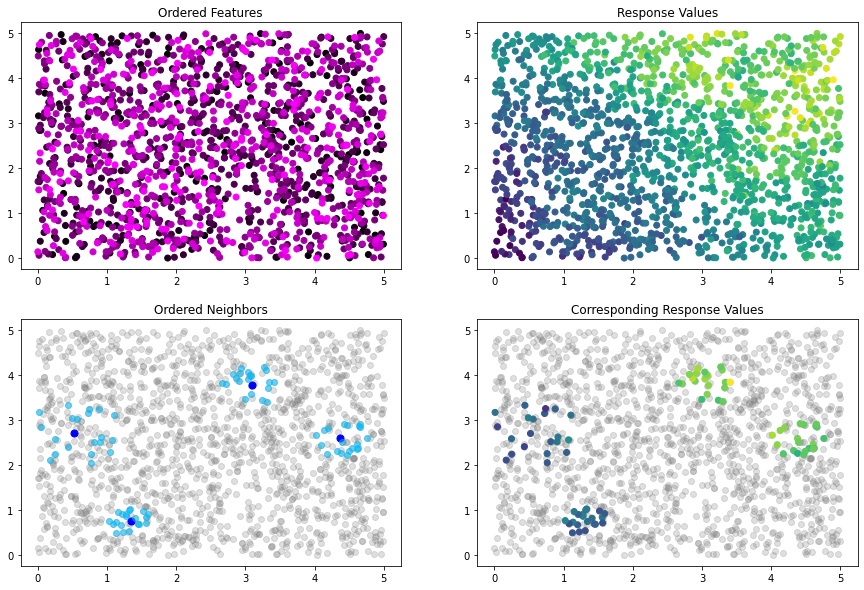

In [10]:
idx_plot(nn_idx, x_train, y_train, n_blocks=4, seed=12345)

At this point, the data is ordered randomly, as the K-Means algorithm that we use does not order the clusters it creates. We can see this random ordering in the *Ordered Features* plot presented above, which colors each point by its index in the dataset. Since the ordering is random, this plot is homogenous.

The `nn_idx` object contains all of the information about our ordered dataset and the neighbor relationships contained within. You can access this information with the `blocks` and `neighbors` properties. Let's look at the first 10 blocks with the `blocks` property.

In [11]:
help(Index.blocks)

Help on property:

    List of tensors where the ith tensor contains the indices of the training set points belonging to block i.


In [12]:
nn_idx.blocks[:10]

[tensor([0]),
 tensor([1]),
 tensor([2]),
 tensor([3]),
 tensor([4]),
 tensor([5]),
 tensor([6]),
 tensor([7]),
 tensor([8]),
 tensor([9])]

From the description given above, we can interpret this as follows

The first block contains a single observation, which is located at index `0` in the training set.
The second block contains a single observation, which is located at index `1` in the training set.
...
The tenth block contains a single observation, which is located at index `9` in the training set.

So, suppose we want to get the x-values of the observation that belongs to the 8th block. We can do this as follows:

In [13]:
x_train[nn_idx.blocks[7]]

tensor([[4.6713, 1.0063]])

Similarly, we can use the `neighbors` property to look at the *neighbors* of the first 10 blocks.

In [14]:
help(Index.neighbors)

Help on property:

    List of tensors, where the ith tensor contains the indices of the training set points belonging to the
    neighbor set of block i.


In [15]:
nn_idx.neighbors[:10]

[tensor([], dtype=torch.int64),
 tensor([0]),
 tensor([1, 0]),
 tensor([1, 2, 0]),
 tensor([1, 2, 3, 0]),
 tensor([1, 3, 2, 0, 4]),
 tensor([4, 5, 1, 2, 3, 0]),
 tensor([0, 3, 1, 5, 2, 6, 4]),
 tensor([6, 5, 2, 1, 4, 3, 7, 0]),
 tensor([5, 7, 0, 1, 3, 4, 6, 8, 2])]

Again, we can interpret this as follows:

The first block has zero neighboring observations.
The second block has one neighboring observation, which is located at index `0` in the training set.
...
The tenth block has nine neighboring observations, which are located at indices `5`,`7`,`0`,`1`,`3`,`4`,`6`,`8`, and `2` in the training set.

Suppose we want to get the x-values of the observations that neighbor the 8th block. We can do this as follows:

In [16]:
x_train[nn_idx.neighbors[7]]

tensor([[4.8758, 0.5135],
        [4.4927, 2.3013],
        [4.0158, 2.6609],
        [3.4642, 2.8199],
        [4.6961, 3.5706],
        [1.8742, 4.5346],
        [0.3540, 4.4093]])

The y-values can be accessed in exactly the same way:

In [17]:
y_train[nn_idx.neighbors[7]]

tensor([5.4464, 5.6988, 5.9415, 5.3963, 5.8806, 5.5956, 4.9574])

We can use this information to build a plot of the 8th block, shown in dark blue, and its associated associated neighbors, shown in light blue.

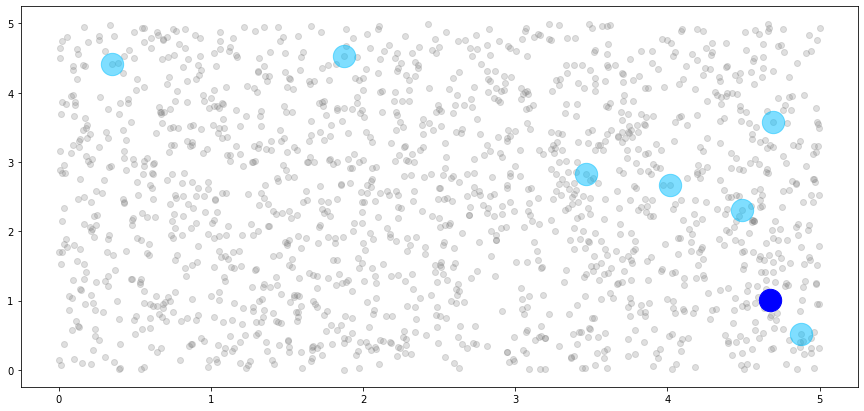

In [18]:
# create light grey plot to show whole dataset
plt.scatter(x_train[:,0].numpy(), x_train[:,1].numpy(), color="grey", alpha=0.25)

# plot the single observation in the 8th block
plt.scatter(x_train[nn_idx.blocks[7]][:,0].numpy(),
            x_train[nn_idx.blocks[7]][:,1].numpy(),
            c="blue", s=500)

# plot the neighbors of the 8th block
plt.scatter(x_train[nn_idx.neighbors[7]][:,0].numpy(),
            x_train[nn_idx.neighbors[7]][:,1].numpy(),
            c="deepskyblue", s=500, alpha=0.5)

plt.show()

We can see that the single observation in the 8th block has five neighbors, just as we specified. However, these don't look like neighbors! This is because our blocks are unordered, and the observations that are allowed to be considered neighbors of the 8th block are essentially a random sample from our dataset. So, let's impose a new ordering structure.

### Ordering Strategies

As discussed in the introduction, there are many many different ways to order datasets to achieve better performance in nearest-neighbor GP models. We've collected these different ways to order the data into an interface called `OrderingStrategies`, also located in GPyTorch's `nearest_neighbors` module.

In [19]:
from gpytorch.nearest_neighbors import OrderingStrategies

One of the most common ordering strategies is to order the data by the x or y coordinates. We have a `coordinate_ordering` method in `OrderingStrategies` that allows you to order by any column in your dataset. Ordering by the first column corresponds to an x-coordinate ordering, while ordering by the second column corresponds to a y-coordinate ordering.

The `KMeansIndex` includes a `reorder` method that accepts a method from `OrderingStrategies` and reorders the blocks using the block centroids. Importantly, this is an **in place operation**. This means that the `reorder` method does not return a new `KMeansIndex` instance with a new order, but reorders the blocks already stored in the `KMeansIndex` instance. Let's see it all in action.

In [20]:
nn_idx.reorder(OrderingStrategies.coordinate_ordering(0)) # order by first column, x-coordinate ordering

Now, we can use our `plot` method to see how the ordering has changed:

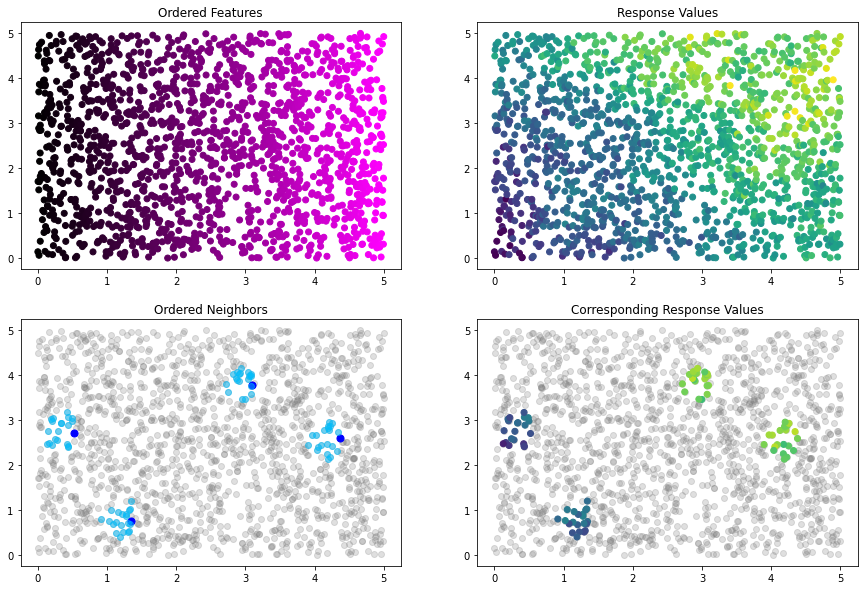

In [21]:
idx_plot(nn_idx, x_train, y_train, n_blocks=4, seed=12345)

Our `blocks` and `neighbors` properties have changed to reflect the updated order.

In [22]:
nn_idx.blocks[:10]

[tensor([1438]),
 tensor([581]),
 tensor([875]),
 tensor([115]),
 tensor([50]),
 tensor([747]),
 tensor([531]),
 tensor([1382]),
 tensor([737]),
 tensor([16])]

In [23]:
nn_idx.neighbors[:10]

[tensor([], dtype=torch.int64),
 tensor([1438]),
 tensor([ 581, 1438]),
 tensor([ 875,  581, 1438]),
 tensor([ 875,  115,  581, 1438]),
 tensor([ 115,  581,  875,   50, 1438]),
 tensor([ 115,  875,  747,   50,  581, 1438]),
 tensor([ 581,  747, 1438,  115,  531,  875,   50]),
 tensor([1438, 1382,  581,  747,  115,  531,  875,   50]),
 tensor([ 581, 1382,  747,  115, 1438,  737,  531,  875,   50])]

We can also reuse the plot from earlier to view the new 8th block and its associated neighbors.

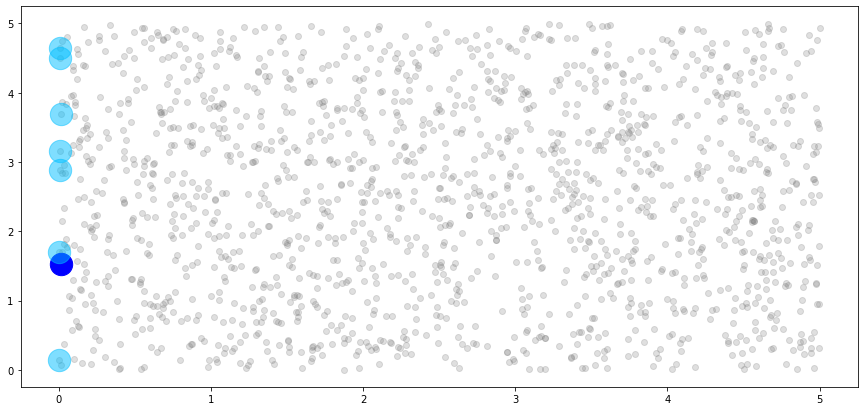

In [24]:
# create light grey plot to show whole dataset
plt.scatter(x_train[:,0].numpy(), x_train[:,1].numpy(), color="grey", alpha=0.25)

# plot the single observation in the 8th block
plt.scatter(x_train[nn_idx.blocks[7]][:,0].numpy(),
            x_train[nn_idx.blocks[7]][:,1].numpy(),
            c="blue", s=500)

# plot the neighbors of the 8th block
plt.scatter(x_train[nn_idx.neighbors[7]][:,0].numpy(),
            x_train[nn_idx.neighbors[7]][:,1].numpy(),
            c="deepskyblue", s=500, alpha=0.5)

plt.show()

So far, we have the ability to block datasets with K-means (in the NNGP example, each block has a single observation), to access blocks and block neighbors via their indices, and to reorder the blocks using the x or y coordinates of the features. Additionally, all of the neighboring relationships obey the ordering constraints discussed in the first section.

However, we also need the ability to determine block membership and neighboring observations for a given testing dataset, since nearest-neighbor models incorporate the training observations that neighbor test points during inference. Fortunately, this is incredibly easy with the `KMeansIndex`! Let's see how it works.

### Working with Test Sets

To determine block membership and neighboring observations of testing data, we use the `block_new_data` method of our `KMeansIndex` instance. This method will determine which training block each new test observation belongs to, and will identify the training blocks that neighbor each test block.

In [25]:
nn_idx.block_new_data(x_test)

Now that this method has been called, we have access to two new properties, `test_blocks` and `test_neighbors`. These properties carry the same information and interpretation as `blocks` and `neighbors`, but for the dataset that you passed to `block_new_data`.

In [26]:
help(Index.test_blocks)

Help on property:

    List of tensors where the ith tensor contains the indices of the testing set points belonging to block i.
    Only defined after block_new_data has been called.


In [27]:
nn_idx.test_blocks[:10]

[tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([ 63, 229]),
 tensor([], dtype=torch.int64)]

We interpret this as follows:

The first block contains no observations from the testing set.
The second block contains no observations from the testing set.
...
The ninth block contains two observations from the testing set, which are located at indices `63` and `229` in the testing set.

It is important to know that nearest-neighbors models do not consider test observations to be neighbors of other test observations. Rather, the neighbors of the testing points in a block are defined as all of the training observations contained within that block, as well as the training observations in that block's neighbors.

In [28]:
help(Index.test_neighbors)

Help on property:

    List of tensors, where the ith tensor contains the indices of the training set points belonging to the
    neighbor set of the ith test block. Importantly, the neighbor sets of test blocks only consist of training
    points. Only defined after block_new_data has been called.


In [29]:
nn_idx.test_neighbors[:10]

[tensor([1438]),
 tensor([ 581, 1438]),
 tensor([ 875,  581, 1438]),
 tensor([ 115,  875,  581, 1438]),
 tensor([  50,  875,  115,  581, 1438]),
 tensor([ 747,  115,  581,  875,   50, 1438]),
 tensor([ 531,  115,  875,  747,   50,  581, 1438]),
 tensor([1382,  581,  747, 1438,  115,  531,  875,   50]),
 tensor([ 737, 1438, 1382,  581,  747,  115,  531,  875,   50]),
 tensor([  16,  581, 1382,  747,  115, 1438,  737,  531,  875,   50])]

We interpret this as follows:

Testing observations appearing in the first block have one neighbor, which is located at index `1438` in the training set.
Testing observations appearing in the second block have two neighbors, which are located at indices `581` and `1438` in the training set.
...
Testing observations appearing in the ninth block have six neighbors, which are located at indices `16`,`581`,`1382`,`747`,`115`,`1438`,`737`,`531`,`875` and `50` in the training set.

Now that we have covered the K-means index in-depth for NNGP, we will run through the same features for a Block-Nearest-Neighbors implementation so you can see another way the interface may be used.

### Index for Block-NNNGP With K-Means

In [30]:
# construct BNN index with 50 total blocks and 3 neighboring blocks per block, using K-means to create blocks
# and the Manhattan distance metric to measure distances between blocks
bnn_idx = Index(x_train, n_blocks=50, n_neighbors=3,
                distance_metric=DistanceMetrics.manhattan_distance())

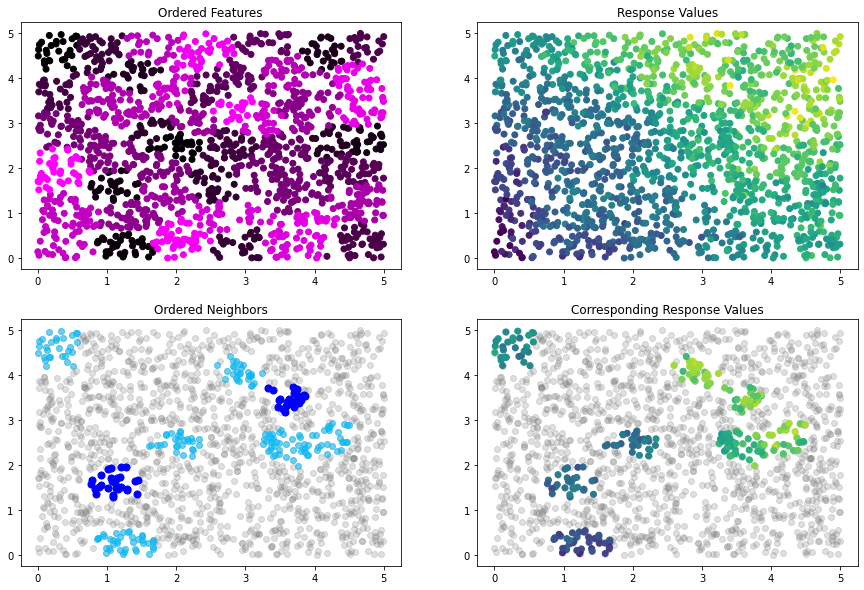

In [31]:
idx_plot(bnn_idx, x_train, y_train, n_blocks=2, seed=12345)

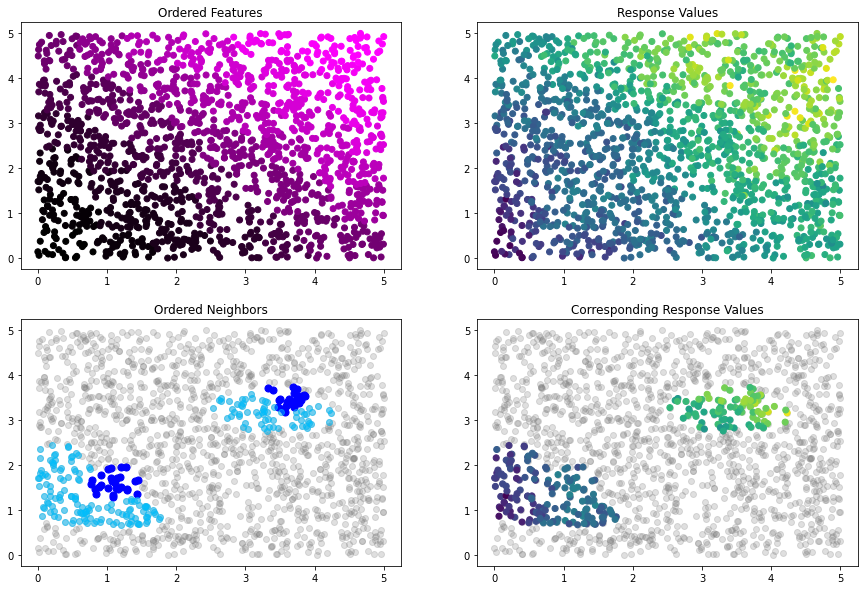

In [32]:
# reorder by L1 norm so that neighbors make more sense. arguments passed to torch.linalg.norm
bnn_idx.reorder(OrderingStrategies.norm_ordering(p=1, dim=1))
# plot new ordering
idx_plot(bnn_idx, x_train, y_train, n_blocks=2, seed=12345)

In [33]:
# get training indices of first 5 blocks
bnn_idx.blocks[:5]

[tensor([  75,   76,   80,  120,  144,  151,  184,  223,  283,  313,  344,  533,
          595,  672,  731,  737,  822,  962, 1058, 1060, 1079, 1280, 1305, 1362,
         1403, 1438, 1442, 1454]),
 tensor([  31,   40,   60,   79,  125,  136,  175,  208,  216,  258,  347,  361,
          390,  460,  501,  564,  604,  616,  619,  688,  691,  797,  808,  810,
          834,  894,  900,  914,  954, 1042, 1053, 1068, 1088, 1118, 1157, 1180,
         1233, 1254, 1258, 1308, 1316, 1361, 1369, 1392, 1504, 1567, 1569]),
 tensor([   9,   47,   55,  160,  194,  237,  326,  514,  571,  609,  628,  698,
          716,  783,  792,  801,  859,  889,  893,  910,  944,  969,  975,  996,
         1032, 1057, 1099, 1111, 1145, 1192, 1202, 1339, 1395, 1399, 1410, 1419,
         1440, 1583]),
 tensor([  16,   20,   58,   93,  171,  178,  242,  287,  320,  341,  355,  432,
          452,  513,  544,  581,  697,  733,  836,  884,  908,  913,  966,  986,
         1030, 1129, 1155, 1176, 1206, 1210, 1289, 1335

In [34]:
# get first 10 observations in the fifth block
x_train[bnn_idx.blocks[4]][:10]

tensor([[1.0241, 0.7604],
        [1.1364, 0.7258],
        [1.5472, 1.0783],
        [1.3337, 1.0204],
        [1.4597, 1.0985],
        [1.5948, 0.9167],
        [1.4113, 0.8133],
        [1.3525, 1.2434],
        [1.6839, 0.9502],
        [1.5583, 0.8334]])

In [35]:
# get indices of first 10 neighbors for each of the first 5 blocks
[bnn_idx.neighbors[block][:10] for block in range(5)]

[tensor([], dtype=torch.int64),
 tensor([ 75,  76,  80, 120, 144, 151, 184, 223, 283, 313]),
 tensor([ 75,  76,  80, 120, 144, 151, 184, 223, 283, 313]),
 tensor([ 31,  40,  60,  79, 125, 136, 175, 208, 216, 258]),
 tensor([  9,  47,  55, 160, 194, 237, 326, 514, 571, 609])]

In [36]:
# get first 10 observations that neighbor the fifth block
x_train[bnn_idx.neighbors[4]][:10]

tensor([[1.0417, 0.1160],
        [1.2418, 0.0655],
        [0.8764, 0.3684],
        [1.5087, 0.4350],
        [1.1938, 0.3959],
        [1.2275, 0.5092],
        [1.1509, 0.3116],
        [0.9564, 0.4155],
        [1.6644, 0.2836],
        [1.2574, 0.1304]])

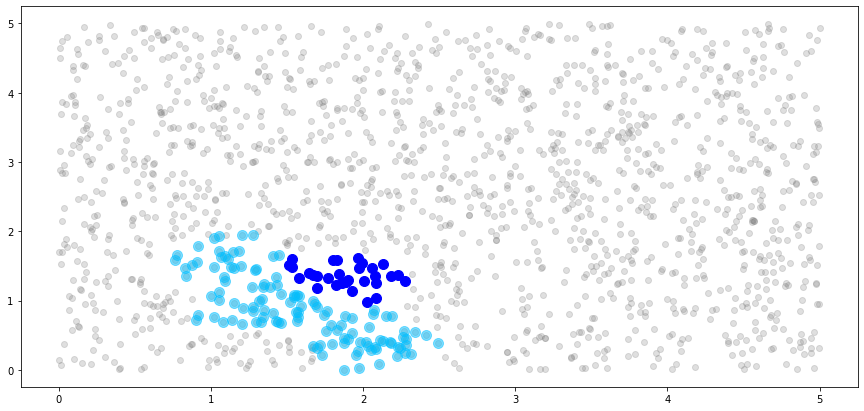

In [37]:
# create light grey plot to show whole dataset
plt.scatter(x_train[:,0].numpy(), x_train[:,1].numpy(), color="grey", alpha=0.25)

# plot the observations in the 8th block
plt.scatter(x_train[bnn_idx.blocks[7]][:,0].numpy(),
            x_train[bnn_idx.blocks[7]][:,1].numpy(),
            color="blue",  s=100)

# plot the neighbors of the 8th block
plt.scatter(x_train[bnn_idx.neighbors[7]][:,0].numpy(),
            x_train[bnn_idx.neighbors[7]][:,1].numpy(),
            color="deepskyblue", s=100, alpha=0.5)

plt.show()

In [38]:
# block testing dataset
bnn_idx.block_new_data(x_test)

In [39]:
# get indices of testing observations that belong to first 5 blocks
bnn_idx.test_blocks[:5]

[tensor([ 28,  39,  53,  63,  73,  94,  98, 219, 229, 293, 300, 329, 341, 362]),
 tensor([126, 150, 190, 230, 292, 294, 361, 368, 375, 380, 397]),
 tensor([ 21,  77, 116, 189, 205, 244, 326]),
 tensor([135, 159, 164, 216, 253, 299, 370]),
 tensor([ 79, 183, 302])]

In [40]:
# get first 10 testing observations that belong to the first block
x_test[bnn_idx.test_blocks[0]][:10]

tensor([[0.4509, 0.2657],
        [0.7710, 0.0426],
        [0.7796, 0.2184],
        [0.0410, 0.0404],
        [0.3419, 0.3542],
        [0.7673, 0.5754],
        [0.2620, 0.1480],
        [0.5390, 0.5044],
        [0.0339, 0.0729],
        [0.2726, 0.2219]])

In [41]:
# get indices of first 10 testing neighbors for each of the first 5 blocks
[bnn_idx.test_neighbors[block][:10] for block in range(5)]

[tensor([ 75,  76,  80, 120, 144, 151, 184, 223, 283, 313]),
 tensor([ 31,  40,  60,  79, 125, 136, 175, 208, 216, 258]),
 tensor([  9,  47,  55, 160, 194, 237, 326, 514, 571, 609]),
 tensor([ 16,  20,  58,  93, 171, 178, 242, 287, 320, 341]),
 tensor([ 19, 132, 185, 198, 222, 325, 340, 372, 411, 413])]

In [42]:
# get first 10 observations that neighbor testing observations in the first block
x_train[bnn_idx.test_neighbors[0]][:10]

tensor([[0.2126, 0.0808],
        [0.4038, 0.3756],
        [0.2409, 0.4863],
        [0.5437, 0.0119],
        [0.3986, 0.0118],
        [0.5616, 0.0423],
        [0.5498, 0.5835],
        [0.0350, 0.3785],
        [0.0889, 0.5727],
        [0.6715, 0.3079]])

Hopefully you can see how easy it is to access all of the information you might need about the blocks and neighbors with just four properties: `blocks`, `neighbors`, `test_blocks`, and `test_neighbors`.

### NNGP with Voronoi Diagrams

Now, we have covered all of this information for K-Means, but what about other clustering algorithms? For example, the Voronoi Diagram is a popular alternative to K-Means in the spatial statistics community. We encourage you to navigate to the 6th cell of code in this notebook and replace

```Python
from gpytorch.nearest_neighbors import KMeansIndex as Index
```

with

```Python
from gpytorch.nearest_neighbors import VoronoiIndex as Index
```

and re-run the notebook to see what happens. The interface is identical to the K-Means case, but the internals of the index will use a Voronoi diagram to determine blocks and neighbors rather than K-Means clustering. This makes it incredibly easy to compare different clustering algorithms and ordering strategies to find what best suits your needs, without having to change any part of the rest of your code.